In [33]:
import os

import torchaudio.transforms as T
import pandas as pd
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models, transforms
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

In [35]:
def funcaudioname(audio_files,audio_num):
    for aud in audio_files:
        if aud.split('_')[0] == audio_num:
            return aud
    return None

In [ ]:
df = pd.read_csv('Music.csv')

data = df[df['Singer'] != 'Unlabelled']
data_ =  data[data['Singer'] != 'Other']
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for singer in data['Singer'].unique():
  singer_data = data[data['Singer'] == singer]

  train_data = pd.concat([train_data, singer_data.head(8)])
  test_data = pd.concat([test_data, singer_data.tail(len(singer_data) - 8)])

classes = train_data['Singer'].unique()

In [37]:
class get_data(Dataset):
    def __init__(self, data,phase='training', target_sr=44100, device='cpu',chunk_dur = 30):
        self.data = data
        self.data = self.data[self.data['Singer'] != 'Unlabelled']
        self.target_sr = target_sr
        self.chunk_dur = chunk_dur
        self.chunk_len = int(self.target_sr*self.chunk_dur)
        self.device = torch.device(device)
        self.phase = phase.upper()
            
        self.singers = self.data['Singer'].unique()
        self.singer_to_idx = {singer: idx for idx, singer in enumerate(self.singers)}

        self.get_mel = T.MelSpectrogram(
            sample_rate=self.target_sr,
            n_fft=1280,
            n_mels=128,
            f_min=15,
            f_max=14000,
            hop_length=400,
            power=1.5
        ).to(self.device)

    def _fix_length(self, audio):
        if audio.shape[1] < self.chunk_len:
            pad_amount = self.chunk_len - audio.shape[1]
            audio = torch.nn.functional.pad(audio, (0, pad_amount))
        else:
            audio = audio[:, :self.chunk_len]
        return audio

    def _preprocess(self, audio, sr):
        if audio.shape[0] > 1:
            audio = torch.mean(audio, dim=0).unsqueeze(0)
        if sr != self.target_sr:
            resampler = T.Resample(orig_freq=sr, new_freq=self.target_sr).to(self.device)
            audio = resampler(audio)
        audio = self._fix_length(audio)
        mel_spec = self.get_mel(audio)
        return audio, mel_spec

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audioname = self.data.iloc[idx]['Audio Path']
        source = self.data.iloc[idx]['Source']
        path = '../../../DATA/datasets/PB/train/M/M'
        path_ = '/home/surge_siya/YT'

        if source == 'PB':
            audio_files = os.listdir(path)
            audio_num = audioname.split('_')[0]

            audi = funcaudioname(audio_files,audio_num)
            audio_path = os.path.join(path, audi)
            audio, sr = torchaudio.load(audio_path)
        
        else:
            audio_path = os.path.join(path_, audioname)
            audio, sr = torchaudio.load(audio_path)
        
        audios, mel = self._preprocess(audio = audio.to(self.device), sr = sr)
        singer = self.data.iloc[idx]['Singer']
        label = self.singer_to_idx[singer]
        if self.phase == 'TRAINING':
            return mel, label, singer
        else:
            return mel, audio_path, singer

In [38]:
train_dataset = get_data(train_data,phase='TRAINING')
test_dataset = get_data(test_data,phase='TESTING')
emd_dataset = get_data(data_)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last = True)
emd_loader = DataLoader(emd_dataset, batch_size=32, shuffle=True, drop_last = True)

In [40]:
class MusicResNet18(nn.Module):
    def __init__(self, num_classes, embeddings=False):
        super(MusicResNet18, self).__init__()

        self.resnet = models.resnet18(pretrained=True)
        self.fc = nn.Linear(1000, num_classes)
        self.embeddings = embeddings

    def forward(self, x):
        x = x.expand(x.size(0), 3, x.size(2), x.size(3))  
        out = self.resnet(x)

        if self.embeddings:
            return out
        else:
            lastlayer = self.fc(out)
            return lastlayer

device = 'cuda:2'
num_classes = len(train_dataset.singers)
model = MusicResNet18(num_classes=num_classes, embeddings=False).to(device)

/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learning_rate = 0.001
num_epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = 'cuda:2'
model.to(device)

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for i, (mel_specs, labels) in enumerate(tqdm(train_loader)):
        mel_specs = mel_specs.to(device)
        labels = labels.to(device) 

        outputs = model(mel_specs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

model.eval()

In [ ]:
# with torch.no_grad():
#     for i, (mel_specs, audio_paths, labels) in enumerate(tqdm(test_loader)):
#         mel_specs = mel_specs.to(device)
#         outputs = model(mel_specs)
#         _, predicted = torch.max(outputs.data, 1)
#         for audio_path,singer, pred in zip(audio_paths, labels, predicted):
#             print(f'Audio: {audio_path}, Actual Singer: {singer}, Predicted Singer: {train_dataset.singers[pred]}')

total = 0
correct = 0
with torch.no_grad():
    for i, (mel_specs, audio_paths, labels) in enumerate(tqdm(test_loader)):
        mel_specs = mel_specs.to(device)
        outputs = model(mel_specs)
        _, predicted = torch.max(outputs.data, 1)
        batch_total = 0
        batch_correct = 0
        for audio_path,singer, pred in zip(audio_paths, labels, predicted):
            # print(f'Audio: {audio_path}, Actual Singer: {singer}, Predicted Singer: {train_dataset.singers[pred]}')
            if singer == train_dataset.singers[pred]:
                batch_correct += 1
            batch_total += 1

        correct += batch_correct
        total += batch_total
        print(f'batch_accuracy: {batch_correct/batch_total}')
overall_accuracy = (correct / total) * 100
overall_accuracy

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
import numpy as np

model.load_state_dict(torch.load('/home/surge_siya/modelfinal.pth'))
model.eval()

true_labels = []
predicted_labels = []

train_data_new = train_data[train_data['Singer'] != 'Other']
print(train_data_new)
train_dataset_new = get_data(train_data_new,phase='TESTING')
train_loader_new = DataLoader(train_dataset_new, batch_size=32, shuffle=False, drop_last = True)

with torch.no_grad():
    for i, (mel_specs, labels, singers) in enumerate(tqdm(train_loader_new)):
        mel_specs = mel_specs.to(device)
        outputs = model(mel_specs)
        _, predicted = torch.max(outputs.data, 1)
        for singer, pred in zip(singers, predicted):
            true_singer = train_dataset.singers[pred]
            true_labels.append(singer)
            predicted_labels.append(true_singer)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1_score = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Accuracy:", accuracy)

       Audio Path               Singer Source  Duration
0      827_11.wav  ASLAM SABRI & PARTY     PB      30.0
1    14230_11.wav  ASLAM SABRI & PARTY     PB      30.0
2    14231_11.wav  ASLAM SABRI & PARTY     PB      30.0
3    14243_11.wav  ASLAM SABRI & PARTY     PB      30.0
4    14244_11.wav  ASLAM SABRI & PARTY     PB      30.0
..            ...                  ...    ...       ...
731  46294_11.wav    Chorus (Students)     PB      30.0
732  46298_11.wav    Chorus (Students)     PB      30.0
733  46300_11.wav    Chorus (Students)     PB      30.0
734  46302_11.wav    Chorus (Students)     PB      30.0
735  46303_11.wav    Chorus (Students)     PB      30.0

[552 rows x 4 columns]


100%|██████████| 17/17 [02:30<00:00,  8.84s/it]

Precision: 0.9549019607843138
Recall: 0.9319852941176471
F1 Score: 0.9356736208812332
Accuracy: 0.9319852941176471


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score

test_data_new = test_data[test_data['Singer'] != 'Other']
print(test_data_new)
test_dataset_new = get_data(test_data_new,phase='TESTING')
test_loader_new = DataLoader(test_dataset_new, batch_size=32, shuffle=False, drop_last = True)

true_labels = []
predicted_labels = []

# Loop through the test dataset again to collect true and predicted labels
with torch.no_grad():
    for i, (mel_specs, labels, singers) in enumerate(tqdm(test_loader_new)):
        mel_specs = mel_specs.to(device)
        outputs = model(mel_specs)
        _, predicted = torch.max(outputs.data, 1)
        for singer, pred in zip(singers, predicted):
            true_singer = train_dataset.singers[pred]
            true_labels.append(singer)
            predicted_labels.append(true_singer)

# Convert true and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1_score = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Accuracy:", accuracy)

       Audio Path                   Singer Source  Duration
136  12312_11.wav  MANJUSHA KULKARNI PATIL     PB      30.0
145  14385_11.wav           MANDIRA LAHIRI     PB      30.0
154  12394_11.wav  RITESH & RAJNISH MISHRA     PB      30.0
163  12545_11.wav     VIDUSHI SUMITRA GUHA     PB      30.0
172  11405_11.wav         DR. PANTULA RAMA     PB      30.0
..            ...                      ...    ...       ...
754  46352_11.wav        Chorus (Students)     PB      30.0
755  46359_11.wav        Chorus (Students)     PB      30.0
756  46365_11.wav        Chorus (Students)     PB      30.0
757  46368_11.wav        Chorus (Students)     PB      30.0
758  46370_11.wav        Chorus (Students)     PB      30.0

[207 rows x 4 columns]


100%|██████████| 6/6 [00:49<00:00,  8.22s/it]

Precision: 0.6614836118742369
Recall: 0.46875
F1 Score: 0.5074697429476842
Accuracy: 0.46875



/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
def extract_embeddings(model, dataloader):
    embeddings = []
    singer_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            mel_specs, labels, singers = batch
            # mel_specs = mel_specs.to(device)
            outputs = model(mel_specs)
            embeddings.append(outputs)
            singer_labels.append(singers)
    embeddings = torch.cat(embeddings)
    # singer_labels = torch.cat(singer_labels)
    return embeddings,singer_labels


In [42]:
device_ = torch.device("cpu")
model.load_state_dict(torch.load('/home/surge_siya/modelfinal.pth'))
model.eval()
embeddings, labels = extract_embeddings(model, emd_loader)
concatenated_labels = list(label for inner_tuple in labels for label in inner_tuple)

100%|██████████| 23/23 [04:15<00:00, 11.11s/it]


In [ ]:
import numpy as np
random_classes = np.random.choice(classes, size=10, replace=False)

For 10 random singers

/home/surge_siya/miniconda3/envs/siya/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


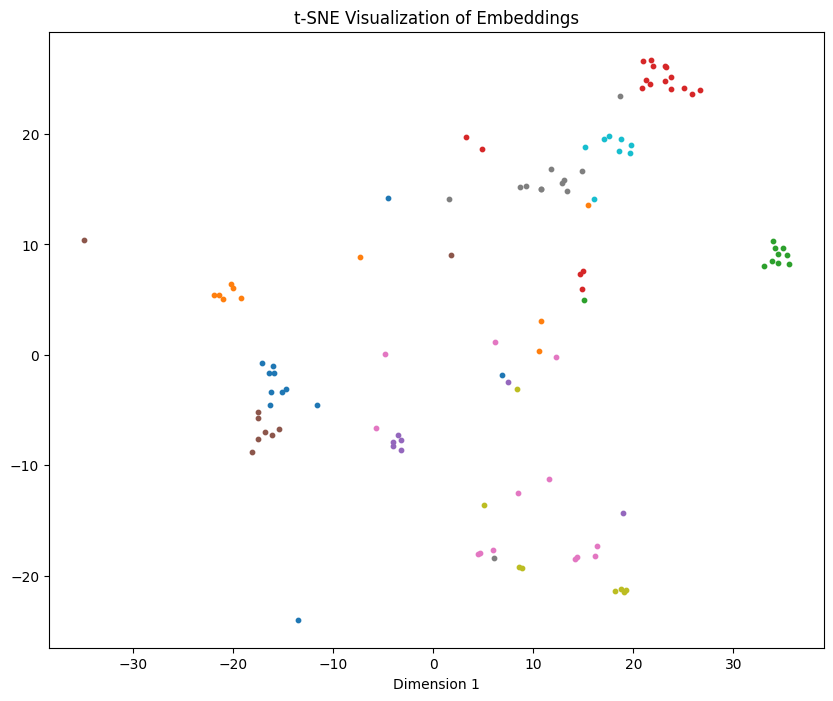

In [48]:
# embeddings = embeddings.cpu().numpy()
tsne = TSNE(n_components=2, random_state=0,perplexity=30, n_iter=5000)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for i in random_classes:
    # indices = np.where(concatenated_labels == i)[0]
    indices = [label == i for label in concatenated_labels]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f'Class {i}', s=10)
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Dimension 1')
# plt.legend(loc='best', fontsize='small', markerscale=2, ncol=2)
plt.show()

70


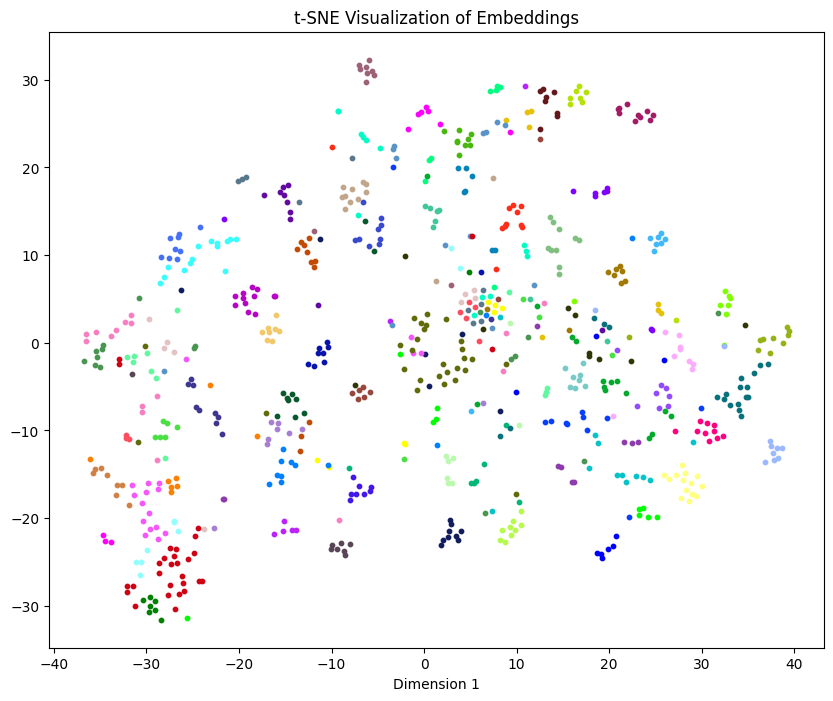

In [27]:
plt.figure(figsize=(10, 8))
for i in classes:
    # indices = np.where(concatenated_labels == i)[0]
    indices = [label == i for label in concatenated_labels]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],color=color_dict[i], label=f'Class {i}', s=10)
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Dimension 1')
# plt.legend(loc='best', fontsize='small', markerscale=2, ncol=2)
plt.show()